<a href="https://colab.research.google.com/github/MattJCR/Practica-DEEP-LEARNING/blob/master/Practica_DEEP_LEARNING_Parte_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalar paquetes adicionales y asegurar que la versión de TensorFlow sea la correcta.

In [ ]:
!pip install opencv-python-headless
!pip install keras
!pip install seaborn
!pip install gdown
import tensorflow as tf
print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.12.0


# Importar librerías y configurar variables.

In [ ]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

# set variables 
main_folder = '../input/celeba-dataset/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000506.jpg'

TRAINING_SAMPLES = 5000
VALIDATION_SAMPLES = 1000
TEST_SAMPLES = 1000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 30

# Descargar y descomprimir CelebFaces.zip

In [ ]:
# Reemplaza YOUR_FILE_ID con el ID del archivo CelebFaces.zip en Google Drive
file_id = '1sYDkBSBEf40i7FHO64uL9wwzS0iRHxXP'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'CelebFaces.zip'

# Descarga el archivo
!gdown {url} -O {output}

# Crear la carpeta '../input/celeba-dataset/' si no existe
os.makedirs('../input/celeba-dataset/', exist_ok=True)

# Descomprimir el archivo en la carpeta deseada
!unzip -q {output} -d '../input/celeba-dataset/'

Downloading...
From: https://drive.google.com/uc?id=1sYDkBSBEf40i7FHO64uL9wwzS0iRHxXP
To: /content/CelebFaces.zip
100% 1.43G/1.43G [00:15<00:00, 90.8MB/s]


# Utilidades

In [ ]:
from tensorflow.keras.utils import to_categorical

def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = to_categorical(df_[attr], 2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

# Tratamiendo de los datos

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


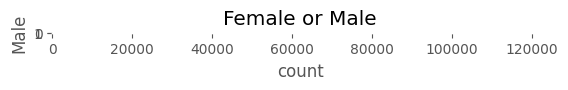

In [ ]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] #some attributes

# Female or Male?
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.show()

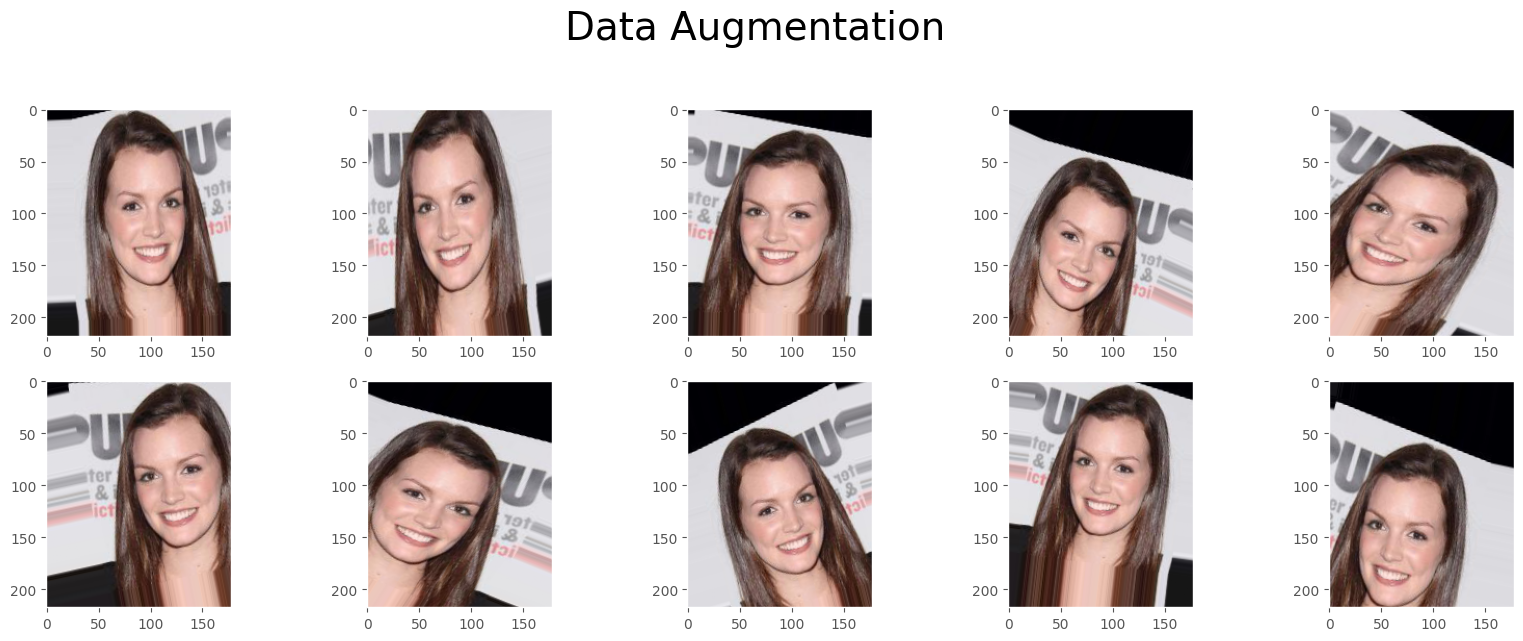

In [ ]:
# Recomended partition
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [ ]:
TRAINING_SAMPLES

5000

In [ ]:
# Train data
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

# Validation Data
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

# Importación del modelo pre-entrenado InceptionV3

In [ ]:
# Import InceptionV3 Model
inc_model = InceptionV3(include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

# Lock initial layers to do not be trained
for layer in inc_model.layers:
    layer.trainable = False

#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# compile the model
model_.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

87910968/87910968 [==============================] - 1s 0us/step
number of layers: 311


# Entrenamiento del modelo

In [ ]:
hist = model_.fit(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , use_multiprocessing = True
                      , verbose=1
                    )

Epoch 1/30
313/312 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.4938
Epoch 1: val_loss improved from inf to 0.68031, saving model to weights.best.inc.male.hdf5
312/312 [==============================] - 95s 258ms/step - loss: 0.6959 - accuracy: 0.4938 - val_loss: 0.6803 - val_accuracy: 0.5870
Epoch 2/30
313/312 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5076
Epoch 2: val_loss did not improve from 0.68031
312/312 [==============================] - 68s 217ms/step - loss: 0.6932 - accuracy: 0.5076 - val_loss: 0.6840 - val_accuracy: 0.5860
Epoch 3/30
313/312 [==============================] - ETA: 0s - loss: 0.6919 - accuracy: 0.5166
Epoch 3: val_loss did not improve from 0.68031
312/312 [==============================] - 67s 212ms/step - loss: 0.6919 - accuracy: 0.5166 - val_loss: 0.6886 - val_accuracy: 0.5760
Epoch 4/30
313/312 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.5382
Epoch 4: val_loss did not imp

# Evaluación del modelo

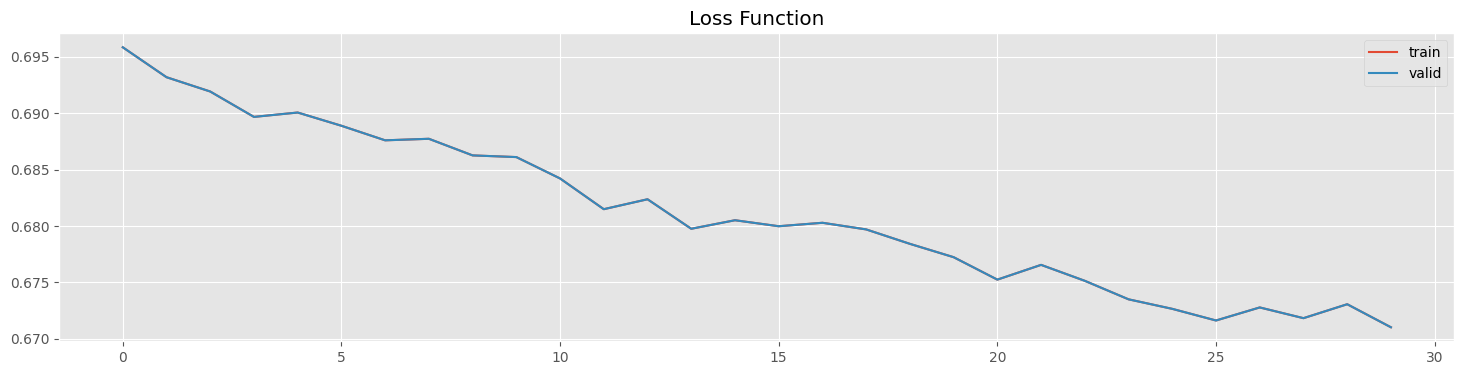

In [ ]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

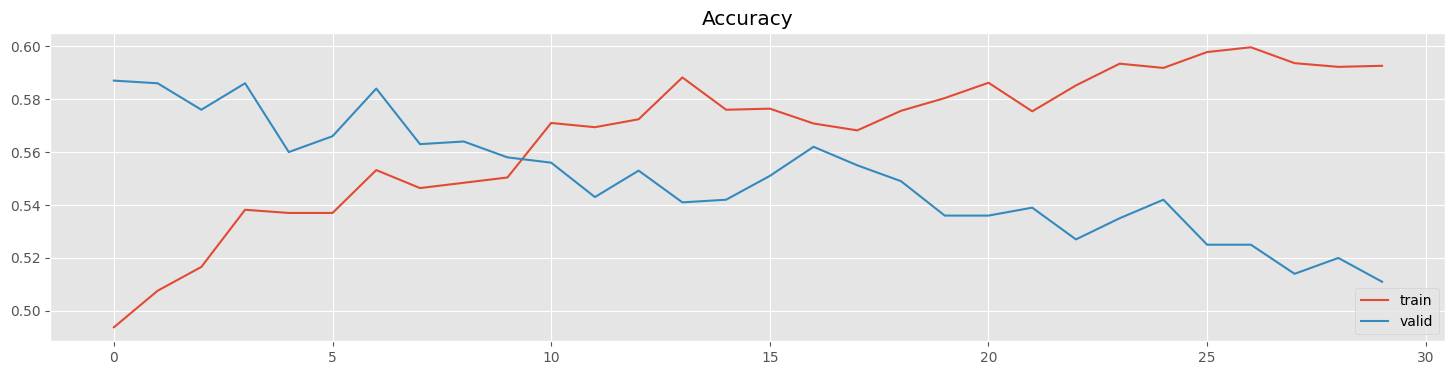

In [ ]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
final_accuracy = hist.history['accuracy'][-1]
final_loss = hist.history['loss'][-1]
final_val_accuracy = hist.history['val_accuracy'][-1]
final_val_loss = hist.history['val_loss'][-1]

print(f"Final training accuracy: {final_accuracy * 100:.2f}%")
print(f"Final training loss: {final_loss}")
print(f"Final validation accuracy: {final_val_accuracy * 100:.2f}%")
print(f"Final validation loss: {final_val_loss}")

Final training accuracy: 59.26%
Final training loss: 0.6710163950920105
Final validation accuracy: 51.10%
Final validation loss: 0.8262013792991638


In [ ]:
test_loss, test_accuracy = model_.evaluate(x_valid, y_valid)

print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss}")

32/32 [==============================] - 2s 54ms/step - loss: 0.8262 - accuracy: 0.5110
Test accuracy: 51.10%
Test loss: 0.8262013792991638
